# Importing Packages

In [1]:
# filter warnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# keras imports
import tensorflow as tf


from tensorflow.keras import preprocessing, callbacks 
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten

# import seaborn as sns
# import tsfel
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, sys, logging, h5py
from PIL import Image
from pathlib import Path as Pathlb


# Custom imports
from scipy import signal
import seaborn as sns


sns.set()

sys.path.insert(0, os.path.abspath(os.path.join('..')))
from MLPackage import Features as feat
from MLPackage import config as cfg


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Setting Logger

In [2]:
project_dir = os.getcwd()[:-5]
log_path = os.path.join(project_dir, 'logs')
temp_dir = os.path.join(project_dir, "temp")

Pathlb(log_path).mkdir(parents=True, exist_ok=True)



def create_logger(level):
    loggerName = "2DCNN_ipynb"
    Pathlb(log_path).mkdir(parents=True, exist_ok=True)
    grey = '\x1b[38;21m'
    blue = '\x1b[38;5;39m'
    yellow = '\x1b[38;5;226m'
    red = '\x1b[38;5;196m'
    bold_red = '\x1b[31;1m'
    reset = '\x1b[0m'

    logger = logging.getLogger(loggerName)
    logger.setLevel(level)
    formatter_colored = logging.Formatter(blue + '[%(asctime)s]-' + yellow + '[%(name)s @%(lineno)d]' + reset + blue + '-[%(levelname)s]' + reset + bold_red + '\t\t%(message)s' + reset, datefmt='%m/%d/%Y %I:%M:%S %p ')
    formatter = logging.Formatter('[%(asctime)s]-[%(name)s @%(lineno)d]-[%(levelname)s]\t\t%(message)s', datefmt='%m/%d/%Y %I:%M:%S %p ')
    file_handler = logging.FileHandler( os.path.join(log_path, loggerName + '_loger.log'), mode = 'w')
    file_handler.setLevel(level)
    file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)

    stream_handler.setFormatter(formatter_colored)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    return logger
logger = create_logger(logging.DEBUG)


logger.info("Importing libraries....")

[12/07/2021 01:43:52 PM ]-[2DCNN_ipynb @37]-[INFO]		Importing libraries....


# Image Preprocessing and Loading

## Loading Images

In [ ]:
logger.info("[INFO] reading dataset....")
with h5py.File(cfg.configs["paths"]["stepscan_dataset"], "r") as hdf:
    barefoots = hdf.get("/barefoot/data")[:]
    metadata = hdf.get("/barefoot/metadata")[:]


data = barefoots.transpose(0,2,3,1)

logger.info(f"barefoots.shape: {data.shape}")
logger.info(f"metadata.shape: {metadata.shape}")
plt.imshow(data[1,:,:,:].sum(axis=2))


## Extracting Image Features

In [ ]:
features = list()
labels = list()

for label, sample in zip(metadata, data):
    # print(np.shape(sample))
    # print(np.max(sample))
    try:
        B = sample.sum(axis=1).sum(axis=0)
        A = np.trim_zeros(sample.sum(axis=1).sum(axis=0))
        aa = np.where(B == A[0])
        bb = np.where(B == A[-1])
        # print(aa[0][0])
        # print(bb[0][0])
        # print(np.trim_zeros(sample.sum(axis=1).sum(axis=0)))

        if aa[0][0]<bb[0][0]:
            features.append(feat.prefeatures(sample[10:70, 10:50, aa[0][0]:bb[0][0]]))
            labels.append(label)
        else:
            print(aa[0][0],bb[0][0])
            k=sample
            l=label
    except:
        continue
    # labels.append(label)
    # break
    # f = np.trim_zeros(sample.sum(axis=1).sum(axis=0),'f').shape[0]
    # b = np.trim_zeros(sample.sum(axis=1).sum(axis=0),'b').shape[0]
    # print(b, f,)

    # temp = np.zeros(sample[:,:,b:f].shape)
    # temp[sample[:,:,b:f] > 5] = 1
    # CD = np.sum(temp, axis=2)

    
        
    # # plt.imshow(sample[:,:,100])
    # print(np.max(sample[:,:,100]))
    # # break
    


logger.info(f"len prefeatures: {len(features)}")
logger.info(f"prefeatures.shape: {features[0].shape}")
logger.info(f"labels.shape: {labels[0].shape}")

np.save(os.path.join(temp_dir, 'prefeatures-SS.npy'), features)
np.save(os.path.join(temp_dir, 'metadata.npy'), labels)

# plt.imshow(CD)

## Loading Image features

In [3]:
Loading_path = os.path.join(temp_dir, 'prefeatures-SS.npy')
prefeatures = np.load(Loading_path)
logger.info("prefeature shape: {}".format(prefeatures.shape))

Loading_path = os.path.join(temp_dir, 'metadata.npy')
metadata = np.load(Loading_path)
logger.info("prefeature shape: {}".format(metadata.shape))

# #CD, PTI, Tmax, Tmin, P50, P60, P70, P80, P90, P100
logger.info("batch_size: {}".format(cfg.configs["CNN"]["batch_size"]))

[12/07/2021 01:43:55 PM ]-[2DCNN_ipynb @3]-[INFO]		prefeature shape: (1743, 60, 40, 10)
[12/07/2021 01:43:56 PM ]-[2DCNN_ipynb @7]-[INFO]		prefeature shape: (1743, 10)
[12/07/2021 01:43:56 PM ]-[2DCNN_ipynb @10]-[INFO]		batch_size: 32


## flatenning Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


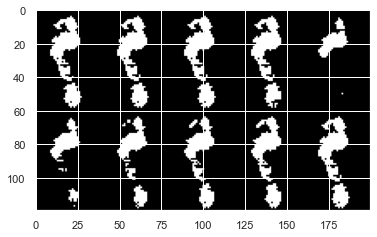

In [4]:
images  = list()
for sample in prefeatures:
    sample = sample.transpose((2, 0, 1))

    total_image = sample[0,:,:]
    total_image1 = sample[5,:,:]

    for i in range(1,5):
        total_image = np.concatenate((total_image, sample[i,:,:]), axis=1)
        total_image1 = np.concatenate((total_image1, sample[i+5,:,:]), axis=1)




    total_image = np.concatenate((total_image, total_image1), axis=0)
    total_image = total_image[:,:, np.newaxis]
    total_image = np.concatenate((total_image, total_image, total_image), axis=2)

    images.append(total_image)

    # plt.figure(figsize=(20,20))
    # plt.imshow( total_image)
    # plt.show()

    # print(type(total_image))
    # print(total_image.dtype)
    # print(total_image.shape)



    # print(result)

    # break
images =np.array(images)
plt.imshow(images[55,...])

In [ ]:

# indices = metadata[:,0]
# depth = len(np.unique(metadata[:,0]))
# one_hot_labels = tf.one_hot(indices, depth)

In [5]:
# CC=tf.keras.utils.to_categorical( metadata[:,0], num_classes=len(np.unique(metadata[:,0])))
# # one_hot_labels==CC
# len(np.unique(metadata[:,0]))
from sklearn import preprocessing as pre
indices = metadata[:,0]
le = pre.LabelEncoder()
le.fit(indices)
le.classes_
indices=le.transform(indices)
len(np.unique(indices))

80

# Making Base Model

In [6]:
try:
    logger.info(f"Loading { cfg.configs['CNN']['base_model'] } model...")
    base_model = eval("tf.keras.applications." + cfg.configs["CNN"]["base_model"] + "(weights=cfg.configs['CNN']['weights'], include_top=cfg.configs['CNN']['include_top'])")
    logger.info("Successfully loaded base model and model...")

except Exception as e: 
    
    base_model = None
    logger.error("The base model could NOT be loaded correctly!!!")
    print(e)


base_model.trainable = False

CNN_name = cfg.configs["CNN"]["base_model"].split(".")[0]

input = tf.keras.layers.Input(shape=cfg.configs["CNN"]["image_size"], dtype = tf.float64, name="original_img")
x = tf.cast(input, tf.float32)
x = eval("tf.keras.applications." + CNN_name + ".preprocess_input(x)")
x = base_model(x)
x = tf.keras.layers.GlobalMaxPool2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', name="last_dense")(x)
output = tf.keras.layers.Dense(cfg.configs['CNN']['class_numbers'], name="prediction")(x) # cfg.configs['CNN']['class_numbers']

[12/07/2021 01:44:32 PM ]-[2DCNN_ipynb @2]-[INFO]		Loading mobilenet.MobileNet model...


[12/07/2021 01:44:34 PM ]-[2DCNN_ipynb @4]-[INFO]		Successfully loaded base model and model...


# The CNN Model

In [7]:
model = tf.keras.models.Model(inputs=input, outputs=output, name=cfg.configs['CNN']['base_model'])

# Freeze the layers 
for layer in model.layers[-2:]:
    layer.trainable = True

# for i,layer in enumerate(model.layers):
#     print(i,layer.name,layer.trainable)

model.summary() 


tf.keras.utils.plot_model(model, to_file=cfg.configs['CNN']['base_model'] + ".png", show_shapes=True)
plt.show()


Model: "mobilenet.MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 120, 200, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 120, 200, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 120, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 120, 200, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                               

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
    )
time = int(timeit.timeit())*1_000_000
checkpoint = [
        callbacks.ModelCheckpoint(
            cfg.configs["CNN"]["saving_path"], save_best_only=True, monitor="val_loss"
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
        callbacks.EarlyStopping( monitor="val_loss", patience=50, verbose=1),
        callbacks.TensorBoard(log_dir='TensorBoard_logs/{time}')
        
    ]    


history = model.fit(
    images,
    indices,
    batch_size=cfg.configs["CNN"]["batch_size"],
    callbacks=[checkpoint],
    epochs= cfg.configs["CNN"]["epochs"],
    validation_split=cfg.configs["CNN"]["validation_split"],
    verbose=cfg.configs["CNN"]["verbose"],
)

Epoch 1/10
44/44 [==============================] - 31s 594ms/step - loss: 8.5985 - accuracy: 0.0079 - val_loss: 8.4944 - val_accuracy: 0.0201 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 27s 613ms/step - loss: 8.2444 - accuracy: 0.0072 - val_loss: 8.2788 - val_accuracy: 0.0229 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 39s 901ms/step - loss: 7.9391 - accuracy: 0.0086 - val_loss: 8.1004 - val_accuracy: 0.0201 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 46s 1s/step - loss: 7.6724 - accuracy: 0.0115 - val_loss: 7.9525 - val_accuracy: 0.0201 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 36s 817ms/step - loss: 7.4383 - accuracy: 0.0115 - val_loss: 7.8289 - val_accuracy: 0.0143 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - ETA: 0s - loss: 7.2322 - accuracy: 0.0115

OSError: Unable to create file (file signature not found)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Extracting features

# Saving Featurs